# はじめに

参考文献：
* マルコフ決定過程やベルマン方程式の話：https://www.amazon.co.jp/dp/4065155916
* マルチステップ方策評価：https://www.jstor.org/stable/2630487
* マルチステップ方策更新：https://arxiv.org/abs/1802.03654

このノートブックでは，テーブルマルコフ決定過程の実装と，そこでのアルゴリズムについて詳しく学びます．

多くの逐次意思決定問題の目標は，その問題における最適な意思決定のルール（方策）を獲得することです．
例えばゲームではプロプレイヤー並みの性能が欲しかったり，将棋では人類の誰よりも強い将棋ソフトが欲しくなったりします．

最適方策はどうやってもとめれば良いでしょうか？
一般の逐次意思決定問題を考えると非常に難しいため，基本的には，**マルコフ決定過程**に問題設定を限定することで簡単なアルゴリズムを導出することが多いです．

まずはマルコフ決定過程を実装してみましょう．特に，最も簡単なマルコフ決定過程である**テーブルマルコフ決定過程**を実装します．


# テーブルマルコフ決定過程を実装しよう
まず，授業のスライドに従って，テーブルマルコフ決定過程を実装しましょう．定義を思い出してください．

1. 有限状態集合: $S=\{1, \dots, |S|\}$
2. 有限行動集合: $A=\{1, \dots, |A|\}$
3. 遷移確率行列: $P\in \mathcal{R}^{S\times A\times S}$
4. 報酬行列: $r\in \mathcal{R}^{S\times A}$
5. 初期状態: $s_0 \in S$

これを実装してみましょう。報酬行列と遷移確率行列はランダムに生成してみます。

In [ ]:
import numpy as np
from dataclasses import dataclass

_S = 3  # 状態集合のサイズ
_A = 2   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合．初期状態は_S_set[0]とします．
_A_set = np.arange(_A)  # 行動集合

# 報酬行列を適当に作ります
_rew = np.random.rand(_S, _A)
assert _rew.shape == (_S, _A)

# 遷移確率行列を適当に作ります
_P = np.random.rand(_S*_A, _S)
_P = _P / np.sum(_P, axis=-1, keepdims=True)  # 正規化して確率にします
_P = _P.reshape(_S, _A, _S)
np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでマルコフ決定過程（MDP）のクラスを作ります
@dataclass
class MDP:
    S_set: np.array  # 状態集合
    A_set: np.array  # 行動集合
    rew: np.array  # 報酬行列
    P: np.array  # 遷移確率行列

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)

    @property
    def s0(self) -> int:  # 初期状態
        return self.S_set[0]


mdp = MDP(_S_set, _A_set, _rew, _P)
print("報酬関数のshape", mdp.rew.shape)
print("遷移確率行列のshape",mdp.P.shape)
print("初期状態", mdp.s0)

報酬関数のshape (3, 2)
遷移確率行列のshape (3, 2, 3)
初期状態 0


これでマルコフ決定過程が定義されました！
試しに状態遷移確率や報酬関数の値を確認してみましょう．例えば$s, a$の次状態の確率分布：

$$P(\cdot |s, a)$$

は``mdp.P[s, a]``を参照すれば得られます。

In [ ]:
s = 2
a = 1
next_s = 0

# "$P(s'|s, a)$と同じ意味です
print(mdp.P[s, a])

# Pはちゃんと遷移確率になっています："$\sum_{s' \in S} P(s'|s, a) = 1$です
print(mdp.P[s, a].sum())

# チャレンジ：s, aの値を変えて，mdp.P[s, a]が確率分布になっているか確認しましょう．どのs, aでも$\sum_{s' \in S} P(s'|s, a) = 1$になっていますか？

[0.45987988 0.25631447 0.28380565]
1.0


方策も行列形式で適当に作ってみましょう．定義を思い出してください．

* 方策：$\pi\in \mathcal{R}^{S\times A}$

In [ ]:
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)

これで方策が定義されました！
試しに各状態行動の値を確認してみましょう．例えば

$$\pi(a|s)$$

の値は``policy[s, a]``を参照すれば得られます。

In [ ]:
print("状態s0での行動の確率分布: ", policy[0])
print("状態s1での行動の確率分布: ", policy[1])
print("状態s2での行動の確率分布: ", policy[2])

# チャレンジ：方策がどのsでも確率分布になっているか確認しましょう！

状態s0での行動の確率分布:  [0.34841676 0.65158324]
状態s1での行動の確率分布:  [0.17355317 0.82644683]
状態s2での行動の確率分布:  [0.23788637 0.76211363]


試しにちょっとだけ逐次意思決定してみましょう．

In [ ]:
s = 0 # 適当な初期状態です
a = np.random.choice(mdp.A, p=policy[s]) # 状態sで，方策π(⋅∣s)から行動をサンプルします
# 状態s, 行動aで，遷移確率P(⋅∣s, a)から次状態をサンプルします
next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
reward = mdp.rew[s, a] # 報酬を得ます
print(f"状態{s}で行動{a}を選択したら次状態{next_s}に遷移し，報酬{reward}を獲得しました")
# 同じことを繰り返します
s = next_s # 次状態を現在の状態とします
a = np.random.choice(mdp.A, p=policy[s])
next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
reward = mdp.rew[s, a]
print(f"状態{s}で行動{a}を選択したら次状態{next_s}に遷移し，報酬{reward}を獲得しました")
s = next_s
# ...

状態0で行動0を選択したら次状態2に遷移し，報酬0.1891654408297344を獲得しました
状態2で行動1を選択したら次状態1に遷移し，報酬0.5456840367425468を獲得しました


## 有限マルコフ決定過程

さっそく作ったマルコフ決定過程と方策で逐次意思決定をしてみましょう．
まずは有限時間の逐次意思決定を確認します．つまり，有限マルコフ決定過程です．

In [ ]:
# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)


s = mdp.s0 # 初期状態です
H = 10 # ホライゾンです
R = 0 # 収益をカウントします
for _ in range(H): # 有限マルコフ決定過程です．
  a = np.random.choice(mdp.A, p=policy[s])
  next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
  reward = mdp.rew[s, a]
  R += reward
  print(f"状態と行動：s={s}, a={a}")
  s = next_s
print("このエピソードの収益：", R)

# チャレンジ：s=0以外からスタートして収益を計算してみましょう．

状態と行動：s=0, a=0
状態と行動：s=0, a=1
状態と行動：s=0, a=1
状態と行動：s=0, a=1
状態と行動：s=0, a=1
状態と行動：s=0, a=1
状態と行動：s=1, a=0
状態と行動：s=1, a=1
状態と行動：s=2, a=1
状態と行動：s=1, a=0
このエピソードの収益： 5.488506004380774


続いて，有限マルコフ決定過程における期待収益をモンテカルロ近似してみましょう．

In [ ]:
# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)


H = 10 # ホライゾンです
R_sum = 0 # 期待収益の計算用です
N = 1000 # モンテカルロ近似で使用するサンプルの数です．

for _ in range(N):
  s = mdp.s0 # 初期状態です
  R = 0 # 収益をカウントします
  for _ in range(H):
    a = np.random.choice(mdp.A, p=policy[s])
    next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
    reward = mdp.rew[s, a]
    R += reward
    s = next_s
  R_sum += R
print("モンテカルロ近似された期待収益:", R_sum / N)

# チャレンジ：Nの値を変えて挙動を観察しましょう．何が言えますか？
# チャレンジ：初期状態をs=0以外から始めてみましょう．

モンテカルロ近似された期待収益: 5.247276157984284


## 無限マルコフ決定過程

続いて無限時間の逐次意思決定を確認してみましょう．割引率が導入されていることに注意してください．（なぜ導入されているか考えてみましょう．スライドでも説明しましたね）

In [ ]:
# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)


s = mdp.s0 # 初期状態です
R = 0 # 割引収益をカウントします
gamma = 0.7 # 割引率です
t = 0 # 経過したステップ数です
while True: # 無限マルコフ決定過程です．
  a = np.random.choice(mdp.A, p=policy[s])
  next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
  reward = mdp.rew[s, a]
  R += gamma ** t * reward
  s = next_s
  print(f"{t}ステップ目までの割引収益：", R)
  t += 1

  if t == 30:  # 無限に実行するとプログラム上はキリがないので，適当なところで切り上げます
    break

# チャレンジ：割引率を変えて挙動を観測してみましょう．また，切り上げるステップはどのくらいが良いでしょうか？

0ステップ目までの割引収益： 0.1891654408297344
1ステップ目までの割引収益： 0.6199562108460346
2ステップ目までの割引収益： 0.7126472768526044
3ステップ目までの割引収益： 0.7775310230572033
4ステップ目までの割引収益： 0.8229496454004226
5ステップ目までの割引収益： 0.8547426810406761
6ステップ目までの割引収益： 0.948580175256707
7ステップ目までの割引収益： 0.9992622785583547
8ステップ目までの割引収益： 1.034739750869508
9ステップ目までの割引収益： 1.042373258726733
10ステップ目までの割引収益： 1.0614838423190962
11ステップ目までの割引収益： 1.0748612508337505
12ステップ目までの割引収益： 1.0774795440287785
13ステップ目までの割引収益： 1.0793123492652983
14ステップ目までの割引収益： 1.08301330430734
15ステップ目までの割引収益： 1.0839113788732346
16ステップ目までの割引収益： 1.084540031069361
17ステップ目までの割引収益： 1.0849800876066493
18ステップ目までの割引収益： 1.0858686869122436
19ステップ目までの割引収益： 1.0860843146155148
20ステップ目までの割引収益： 1.0862352540078046
21ステップ目までの割引収益： 1.0865400435696235
22ステップ目までの割引収益： 1.0866140038718455
23ステップ目までの割引収益： 1.0867633507571366
24ステップ目までの割引収益： 1.0867995913052253
25ステップ目までの割引収益： 1.0868821227314125
26ステップ目までの割引収益： 1.086899880599976
27ステップ目までの割引収益： 1.0869522931442663
28ステップ目までの割引収益： 1.0869889819252696
29

続いて，無限マルコフ決定過程での期待収益をモンテカルロ近似してみます．
後で便利なので，これは関数にしておきましょう．

In [ ]:
def MonteCarloExpectedReturn(mdp: MDP, gamma: float, policy: np.ndarray, H: int, N: int):
  """期待収益をモンテカルロ法で近似します．
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    policy (np.ndarray): 期待収益を近似したい方策です
    H (int): ∞ホライゾンを打ち切る長さです
    N (int): モンテカルロ近似で使用するサンプルの数です．
  """
  R_sum = 0 # 期待収益の計算用です
  for _ in range(N):
    R = 0 # 収益をカウントします
    s = mdp.s0 # 初期状態です
    # 次のステップからは方策に従って動きます
    for h in range(H):
      a = np.random.choice(mdp.A, p=policy[s])
      next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
      reward = mdp.rew[s, a]
      R += gamma ** h * reward
      s = next_s
    R_sum += R
  return R_sum / N


# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)

gamma = 0.7 # 割引率です
H = 30 # 十分な精度が期待できるホライゾンです
N = 100 # モンテカルロ近似で使用するサンプルの数です．
print("モンテカルロ近似された割引期待収益:", MonteCarloExpectedReturn(mdp, gamma, policy, H, N))

# チャレンジ：割引率を変えて挙動を観測してみましょう．また，切り上げるステップはどのくらいが良いでしょうか？

モンテカルロ近似された割引期待収益: 1.455028698601835


## 具体的な問題を実装してみよう（じゃんけんゲーム）

上ではランダムにマルコフ決定過程を生成し，マルコフ決定過程の「型」を学びました．
今回は具体的な問題（講義で紹介したじゃんけんゲーム）を実装してみましょう．

まずは自明な問題を実装してみます．


### 自明な問題

* プレイ回数：１回
* ルール：じゃんけんに勝つと+1，それ以外は+0の報酬が発生します．
* 情報：A君は(グー，チョキ，パー)=(0.2, 0.5, 0.3)の確率で出してきます．
* ゴール：最も報酬が高くなる手を出してください


逆に言えば，あなたが
* グーを出す：確率0.5で報酬+1，確率0.5で報酬+0
* チョキを出す：確率0.3で報酬+1，確率0.7で報酬+0
* パーを出す：確率0.2で報酬+1，確率0.8で報酬+0

です．これは次のようなマルコフ決定過程を考えることでモデル化できます．（こんな単純なじゃんけんでもちょっと面倒くさいですね）．ちなみに勝率が最も高い手は明らかにグーです．

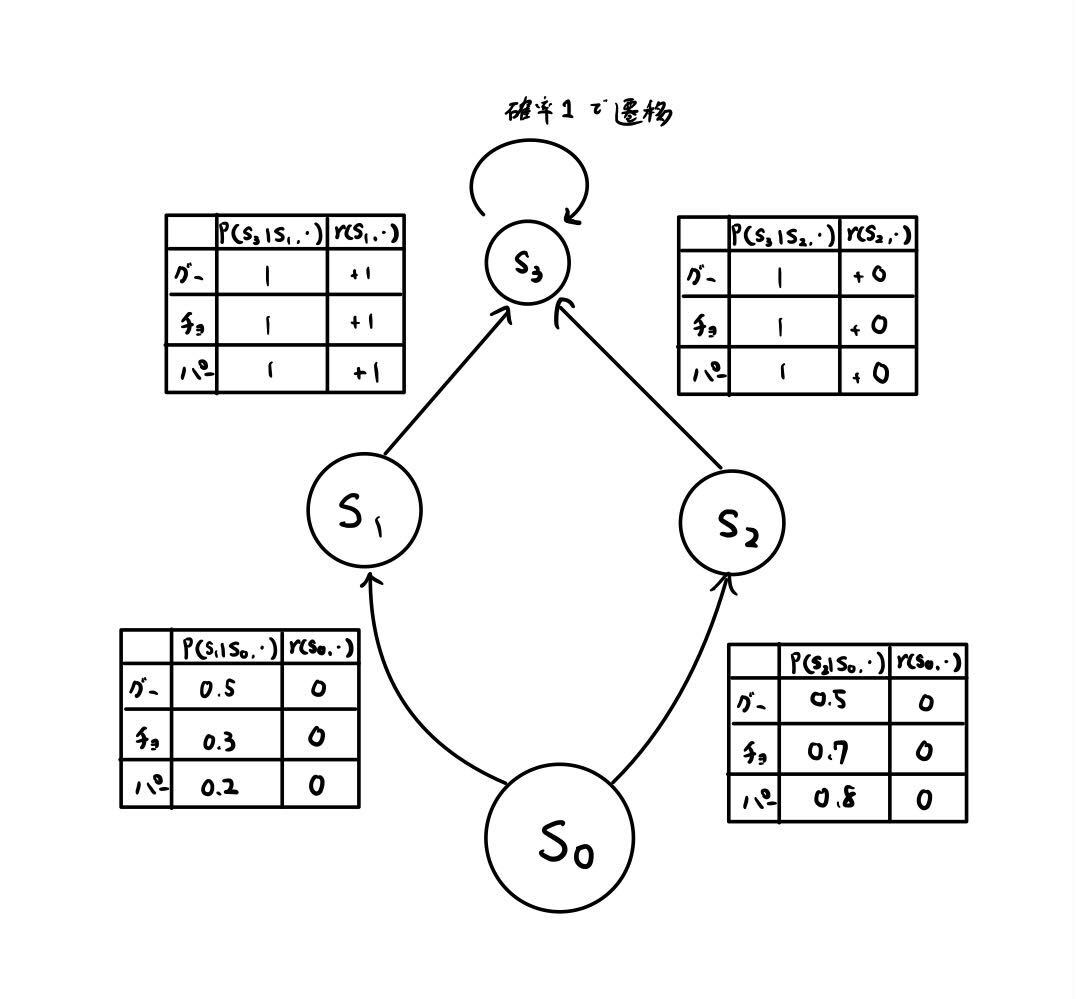

つまり，
* $A=\{0, 1, 2\}$  # グー，チョキ，パー
* $(s_0, s_1, s_2, s_3)$  # ゲーム開始時，あなたが勝った状態，あなたが負け or あいこの状態，ゲーム終了時
* $r$と$P$：上の図を参照してください．


**補足**

問題をどのようなマルコフ決定過程でモデル化するか？には正解はありません．
実は報酬関数の代わりに確率的に発生する報酬を考えると，上の問題は$H=1$でモデル化できます．上の図では意思決定をするタイミングが2回あるので，$H=2$です．
今回の講義では報酬は決定的（つまり，$r(s, a)=実数$でした）としていたので，少し面倒なモデル化をしています．

バンディット問題（$H=1$）などでは報酬が確率的に発生するようにモデル化しますが，強化学習問題（$H\geq 1$）では報酬を決定的にしても，上のように無理やりモデル化できます．これは，報酬の確率的な挙動を遷移の確率的な挙動で表現できるためです．

In [ ]:
# 上のじゃんけんゲームをマルコフ決定過程で表現しましょう

_S = 4  # 状態集合のサイズ
_A = 3   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合
_A_set = np.arange(_A)  # 行動集合

# 報酬行列を作ります
_rew = np.zeros((_S, _A))
_rew[0] = 0  # 状態０では報酬は発生しません
_rew[1] = 1  # 状態１では報酬＋１です
_rew[2] = 0  # 状態２では報酬は発生しません
_rew[3] = 0  # 状態３では報酬は発生しません
assert _rew.shape == (_S, _A)

# 遷移確率行列を作ります
_P = np.zeros((_S, _A, _S))  # 今の状態，今の行動，次状態
_P[:, :, 0] = 0  # ゲーム開始時に戻ることはありません
_P[0, 0, 1] = 0.5  # グーを選んで勝つ確率
_P[0, 0, 2] = 0.5  # グーを選んで負けorあいこの確率
_P[0, 1, 1] = 0.3  # チョキを選んで勝つ確率
_P[0, 1, 2] = 0.7  # チョキを選んで負けorあいこの確率
_P[0, 2, 1] = 0.2  # パーを選んで勝つ確率
_P[0, 2, 2] = 0.8  # パーを選んで負けorあいこの確率
_P[1, :, 3] = 1  # ゲーム終了時に移行する確率
_P[2, :, 3] = 1  # ゲーム終了時に移行する確率
_P[3, :, 3] = 1  # ゲーム終了時に移行する確率
np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します

trivial_mdp = MDP(_S_set, _A_set, _rew, _P)

In [ ]:
print("じゃんけん勝負しましょう．何を出しますか？")
a = int(input("グー: 0，チョキ: 1，パー: 2 "))

s = mdp.s0 # 初期状態です
H = 2 # ホライゾンです
R = 0 # 収益をカウントします
for _ in range(H): # 有限マルコフ決定過程です．
  next_s = np.random.choice(trivial_mdp.S, p=trivial_mdp.P[s, a])
  reward = trivial_mdp.rew[s, a]
  R += reward
  print(f"状態と行動と報酬：s={s}, a={a}, r={reward}")
  s = next_s

if R == 1:
  print("あなたの勝ち")
else:
  print("あなたの負け or あいこ")

### バンディット問題

* プレイ回数：M回
* ルール：じゃんけんに勝つと+1，それ以外は+0の報酬が発生します．
* 情報：A君は(グー，チョキ，パー)=(?, ?, ?)の確率で出してきます．
* ゴール：Mゲーム以内に，最も報酬が高くなる手を見つけてください

上で見た自明な問題と似たような感じですが，今回はA君がどんな手を出してくるかわかりません．なので，A君が何を出しやすいかを当てなければなりません．
このように，環境の情報がない場合＆$H=1$の問題をバンディット問題と呼びます（上のモデル化は厳密には$H=2$ですが，今回使っていない確率的な報酬関数を使用すれば$H=1$にできます）．

In [ ]:
# バンディット問題を体験しましょう

# 状態集合，行動集合，報酬関数は同じです．
_S = 4  # 状態集合のサイズ
_A = 3   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合
_A_set = np.arange(_A)  # 行動集合

_rew = np.zeros((_S, _A))
_rew[0] = 0  # 状態０では報酬は発生しません
_rew[1] = 1  # 状態１では報酬＋１です
_rew[2] = 0  # 状態２では報酬は発生しません
_rew[3] = 0  # 状態３では報酬は発生しません
assert _rew.shape == (_S, _A)


# 遷移確率行列を生成します．我々はA君がどの手を出してくるか知りません．
_P = np.zeros((_S, _A, _S))  # 今の状態，今の行動，次状態
gu_choki_pa = np.random.rand(_A)  # A君が出してくる確率です
gu_choki_pa = gu_choki_pa / gu_choki_pa.sum()
_P[0, 0, 1] = gu_choki_pa[1]  # グーを選んで勝つ確率
_P[0, 0, 2] = 1 - gu_choki_pa[1]  # グーを選んで負けorあいこの確率
_P[0, 1, 1] = gu_choki_pa[2]  # チョキを選んで勝つ確率
_P[0, 1, 2] = 1 - gu_choki_pa[2]  # チョキを選んで負けorあいこの確率
_P[0, 2, 1] = gu_choki_pa[0]  # パーを選んで勝つ確率
_P[0, 2, 2] = 1 - gu_choki_pa[0]  # パーを選んで負けorあいこの確率
_P[1, :, 3] = 1  # ゲーム終了時に移行する確率
_P[2, :, 3] = 1  # ゲーム終了時に移行する確率
_P[3, :, 3] = 1  # ゲーム終了時に移行する確率
np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します

bandit_mdp = MDP(_S_set, _A_set, _rew, _P)

In [ ]:
M = 4  # ゲームのプレイ回数

print(f"全部でゲームを{M}プレイします")
for m in range(M):
  print(f"{m}プレイ目")
  print("じゃんけん勝負しましょう．何を出しますか？")
  a = int(input("グー: 0，チョキ: 1，パー: 2 "))

  s = mdp.s0 # 初期状態です
  H = 2 # ホライゾンです
  R = 0 # 収益をカウントします
  for _ in range(H): # 有限マルコフ決定過程です．
    next_s = np.random.choice(bandit_mdp.S, p=bandit_mdp.P[s, a])
    reward = bandit_mdp.rew[s, a]
    R += reward
    print(f"状態と行動と報酬：s={s}, a={a}, r={reward}")
    s = next_s

  if R == 1:
    print("あなたの勝ち")
  else:
    print("あなたの負け or あいこ")


print(f"A君の出す確率は実は{bandit_mdp.P[0, 2, 1]}, {bandit_mdp.P[0, 0, 1]}, {bandit_mdp.P[0, 1, 1]} でした．当たりましたか？")


### 無限ホライゾンプランニング問題

プレイ回数：1回
* ルール： 無限回じゃんけんをします．パーで勝つと+1，それ以外は0の報酬が発生します．
* 情報：A君は最初必ずグーを出します．次以降，A君は直前に出された手以外を高い確率で出すとします．例えば， (あなた，A君)=(グー，チョキ)なら，次は (0.1, 0.1, 0.8)．また，例えば(あなた，A君)=(グー，グー)なら，次は(0.1, 0.45, 0.45)で手を出します．
* ゴール：適当な$\gamma \in (0, 1)$ に対して，割引累積報酬和が最も高くなる方策を出してください

この場合，A君がどの手を出すか？，の情報は分かっています．
しかし自明な問題と異なり，今回は数ステップ先のことまで考えて，A君なるべくがグーを出すように誘導しないといけません．

ゴールのことはいったんわすれて，このゲームをマルコフ決定過程でモデル化してみましょう．図で表すのは厄介ですが，あり得る状況を整理すれば，簡単にモデル化できます．

* $A=\{0, 1, 2\}$  # グー，チョキ，パー
* $S=(ゲーム開始時, (グ, グ) , (グ, チ), (グ, パ), (チ, グ) , (チ, チ), (チ, パ), (パ, グ) , (パ, チ), (パ, パ))$  # ゲーム開始時と，あなたとA君の手の全列挙です．今回は全部で10個の状態を考えるだけで充分です．順番に$s_0$, $s_1$, ...とします

$P$と$r$は下のコードで確認してください．

In [ ]:
# プランニング問題を体験しましょう

_S = 10  # 状態集合のサイズ
_A = 3   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合
_A_set = np.arange(_A)  # 行動集合

# 報酬行列を作ります
_rew = np.zeros((_S, _A))
_rew[7] = 1  # 状態7では直前に（パ，グ）が出て勝利しているので，報酬を＋１します．
assert _rew.shape == (_S, _A)

# 遷移確率行列を作ります（全部で10x3x10マスあります！）
_P = np.zeros((_S, _A, _S))  # 今の状態，今の行動，次状態
_P[:, :, 0] = 0  # ゲーム開始時に戻ることはありません

# 初期状態ではA君は必ずグーを出します．
_P[0, 0, 1] = 1  # 初期状態 → あなたがグーを出す場合．（グ，グ）に遷移します．
_P[0, 1, 4] = 1  # 初期状態 → あなたがチョキを出す場合．（チ，グ）に遷移します．
_P[0, 2, 7] = 1  # 初期状態 → あなたがパーを出す場合．（パ，グ）に遷移します．

# それ以外のとき
## グーであいこのとき
_P[1, 0, 1] = _P[1, 1, 4] = _P[1, 2, 7]  = 0.1  # A君がグーを出す
_P[1, 0, 2] = _P[1, 1, 5] = _P[1, 2, 8]  = 0.45  # A君がチョキを出す
_P[1, 0, 3] = _P[1, 1, 6] = _P[1, 2, 9]  = 0.45  # A君がパーを出す

## チョキであいこのとき
_P[5, 0, 1] = _P[5, 1, 4] = _P[5, 2, 7]  = 0.45  # A君がグーを出す
_P[5, 0, 2] = _P[5, 1, 5] = _P[5, 2, 8]  = 0.1  # A君がチョキを出す
_P[5, 0, 3] = _P[5, 1, 6] = _P[5, 2, 9]  = 0.45  # A君がパーを出す

## パーであいこのとき
_P[9, 0, 1] = _P[9, 1, 4] = _P[9, 2, 7]  = 0.45  # A君がグーを出す
_P[9, 0, 2] = _P[9, 1, 5] = _P[9, 2, 8]  = 0.45  # A君がチョキを出す
_P[9, 0, 3] = _P[9, 1, 6] = _P[9, 2, 9]  = 0.1  # A君がパーを出す

## (グ, チ)もしくは(チ, グ)のとき
_P[2, 0, 1] = _P[2, 1, 4] = _P[2, 2, 7] = _P[4, 0, 1] = _P[4, 1, 4] = _P[4, 2, 7] = 0.1  # A君がグーを出す
_P[2, 0, 2] = _P[2, 1, 5] = _P[2, 2, 8] = _P[4, 0, 2] = _P[4, 1, 5] = _P[4, 2, 8] = 0.1  # A君がチョキを出す
_P[2, 0, 3] = _P[2, 1, 6] = _P[2, 2, 9] = _P[4, 0, 3] = _P[4, 1, 6] = _P[4, 2, 9] = 0.8  # A君がパーを出す

## (グ, パ)もしくは(パ, グ)のとき
_P[3, 0, 1] = _P[3, 1, 4] = _P[3, 2, 7] = _P[7, 0, 1] = _P[7, 1, 4] = _P[7, 2, 7] = 0.1  # A君がグーを出す
_P[3, 0, 2] = _P[3, 1, 5] = _P[3, 2, 8] = _P[7, 0, 2] = _P[7, 1, 5] = _P[7, 2, 8] = 0.8  # A君がチョキを出す
_P[3, 0, 3] = _P[3, 1, 6] = _P[3, 2, 9] = _P[7, 0, 3] = _P[7, 1, 6] = _P[7, 2, 9] = 0.1  # A君がパーを出す

## (チ, パ)もしくは(パ, チ)のとき
_P[6, 0, 1] = _P[6, 1, 4] = _P[6, 2, 7] = _P[8, 0, 1] = _P[8, 1, 4] = _P[8, 2, 7] = 0.8  # A君がグーを出す
_P[6, 0, 2] = _P[6, 1, 5] = _P[6, 2, 8] = _P[8, 0, 2] = _P[8, 1, 5] = _P[8, 2, 8] = 0.1  # A君がチョキを出す
_P[6, 0, 3] = _P[6, 1, 6] = _P[6, 2, 9] = _P[8, 0, 3] = _P[8, 1, 6] = _P[8, 2, 9] = 0.1  # A君がパーを出す

np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します

planning_mdp = MDP(_S_set, _A_set, _rew, _P)

In [ ]:
print("無限回じゃんけん勝負しましょう．パーで勝つときだけあなたに得点が入ります．得点は次のターンで入ります．")

h = 0
s = mdp.s0  # 初期状態です
R = 0  # 収益をカウントします
gamma = 0.9  # 割引率です

while True:
  print("")
  print("=======何を出しますか？======")
  a = int(input("グー: 0，チョキ: 1，パー: 2 , やめる: 3 "))
  if a == 3:
    break

  next_s = np.random.choice(planning_mdp.S, p=planning_mdp.P[s, a])
  reward = planning_mdp.rew[s, a]
  R += gamma ** h * reward

  if next_s in (1, 4, 7):
    Akun = "グー"
  elif next_s in (2, 5, 8):
    Akun = "チョキ"
  elif next_s in (3, 6, 9):
    Akun = "パー"

  you = {0: "グー", 1: "チョキ", 2: "パー"}[a]
  print(f"あなたの手＝{you}, A君の手＝{Akun}")
  print(f"状態と行動と報酬：s={s}, a={a}, r={reward}")
  print(f"{h}ステップ目の割引収益: {R}")

  h += 1
  s = next_s


### 無限ホライゾン強化学習問題

* プレイ回数：1回
* プレイ回数：1回（無限ホライゾンなので）
* ルール：無限回じゃんけんをします．パーで勝つと+1，それ以外は0の報酬が発生します．
* 情報：A君がどのような条件で何を出すか，一切不明です．
* ゴール：割引累積報酬和が最も高くなる方策を，なるべく少ないじゃんけん数で出してください

今回はとっても難しいです．今回は数ステップ先のことまで考えて手を出さねばならず，しかも，A君が何をいつ出してくるかもわかりません．
これが強化学習問題です．

In [ ]:
# 強化学習問題を体験しましょう

_S = 10  # 状態集合のサイズ
_A = 3   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合
_A_set = np.arange(_A)  # 行動集合

# 報酬行列を作ります
_rew = np.zeros((_S, _A))
_rew[7] = 1  # 状態7では直前に（パ，グ）が出て勝利しているので，報酬を＋１します．
assert _rew.shape == (_S, _A)

# 遷移確率行列を作ります．我々はA君がいつ，どんな手を出してくるか知りません
_P = np.zeros((_S, _A, _S))  # 今の状態，今の行動，次状態
_P = np.random.rand(_S*_A, _S)
_P[:, 0] = 0  # ゲーム開始時に戻ることはありません
_P = _P / np.sum(_P, axis=-1, keepdims=True)  # 正規化して確率にします
_P = _P.reshape(_S, _A, _S)
np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します

RL_mdp = MDP(_S_set, _A_set, _rew, _P)

In [ ]:
print("無限回じゃんけん勝負しましょう．パーで勝つときだけあなたに得点が入ります．得点は次のターンで入ります．")
h = 0
s = mdp.s0  # 初期状態です
R = 0  # 収益をカウントします
gamma = 0.9  # 割引率です

while True:
  print("=======何を出しますか？======")
  a = int(input("グー: 0，チョキ: 1，パー: 2 , やめる: 3 "))
  if a == 3:
    break

  next_s = np.random.choice(RL_mdp.S, p=RL_mdp.P[s, a])
  reward = RL_mdp.rew[s, a]
  R += gamma ** h * reward

  if next_s in (1, 4, 7):
    Akun = "グー"
  elif next_s in (2, 5, 8):
    Akun = "チョキ"
  elif next_s in (3, 6, 9):
    Akun = "パー"

  you = {0: "グー", 1: "チョキ", 2: "パー"}[a]
  print(f"あなたの手＝{you}, A君の手＝{Akun}")
  print(f"状態と行動と報酬：s={s}, a={a}, r={reward}")
  print(f"{h}ステップ目の割引収益: {R}")

  h += 1
  s = next_s

# 動的計画法

## ベルマン方程式とベルマン作用素を確認しよう

**注意：以降は無限マルコフ決定過程についてだけ扱います．**

表記はスライドを参照してください．
マルコフ決定過程で成立する重要な性質がベルマン方程式です．
* ベルマン期待方程式：$Q^\pi = r + \gamma P \langle\pi, Q^\pi\rangle$
* ベルマン最適方程式：$Q^{\pi^*} = r + \gamma P \max_a Q^{\pi^*}$

また，次のベルマン作用素は$Q^\pi$と$Q^{\pi^*}$を見つけるのに便利，ということを学びました．
* ベルマン期待作用素 $B^\pi: \mathbb{R}^{S\times A}\to \mathbb{R}^{S\times A}$：$B^\pi(Q) = r + \gamma P \langle \pi, Q\rangle $
* ベルマン最適作用素 $B: \mathbb{R}^{S\times A}\to \mathbb{R}^{S\times A}$：$B(Q) = r + \gamma P \max_a Q$

ベルマン作用素を使うと，
* ベルマン期待方程式：$Q^\pi = B^\pi(Q^\pi)$
* ベルマン最適方程式：$Q^{\pi^*} = B(Q^{\pi^*})$

と書くこともできます．

以下ではベルマン方程式がちゃんと成り立つか実験するわけですが，先に便利な関数を実装しておきます．

* MonteCarloQ: モンテカルロ近似を使って$Q^\pi$を近似する関数（$Q^\pi(s, a) = \mathbb{E}^\pi[R\mid s_0=s, a_0=a]$であることを思い出しましょう．）
* Bellman_expected_operator: ベルマン期待作用素
* Bellman_optimal_operator: ベルマン最適作用素

の三つを実装してみます．

In [ ]:
def MonteCarloQ(mdp: MDP, gamma: float, s0: int, a0: int, policy: np.ndarray, H: int, N: int):
  """モンテカルロ法でQ\pi(s0, a0)を近似します．
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    s0 (int): 期待収益を近似したい初期状態です
    a0 (int): 期待収益を近似したい初期行動です
    policy (np.ndarray): 期待収益を近似したい方策です
    H (int): ∞ホライゾンを打ち切る長さです
    N (int): モンテカルロ近似で使用するサンプルの数です．
  """
  R_sum = 0 # 期待収益の計算用です
  for _ in range(N):
    R = 0 # 収益をカウントします

    # 最初のステップは初期状態と初期行動で固定されてます
    s = s0  # 初期状態です
    a = a0  # 初期行動です
    next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
    reward = mdp.rew[s, a]
    R += reward
    s = next_s

    # 次のステップからは方策に従って動きます
    for h in range(1, H):
      a = np.random.choice(mdp.A, p=policy[s])
      next_s = np.random.choice(mdp.S, p=mdp.P[s, a])
      reward = mdp.rew[s, a]
      R += gamma ** h * reward
      s = next_s
    R_sum += R
  return R_sum / N


def Bellman_expected_operator(mdp: MDP, gamma: float, Q: np.ndarray, policy: np.ndarray):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    Q (np.ndarray): ベルマン期待作用素に入力するQ関数です
    policy (np.ndarray): ベルマン期待作用素で使う方策です
  """
  S, A = mdp.S, mdp.A
  # 方策とQ関数はSxAの行列です
  assert Q.shape == (S, A)
  assert policy.shape == (S, A)
  policy_Q = (policy * Q).sum(axis=1) # πQです
  P_policy_Q = mdp.P @ policy_Q  # P(πQ)です
  B_policy_Q = mdp.rew + gamma * P_policy_Q # ベルマン期待作用素の結果です
  return B_policy_Q


def Bellman_optimal_operator(mdp: MDP, gamma: float, Q: np.ndarray):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    Q (np.ndarray): ベルマン期待作用素に入力するQ関数です
  """
  # Q関数はSxAの行列です
  assert Q.shape == (mdp.S, mdp.A)
  max_Q = Q.max(axis=1) # maxQです
  P_max_Q = mdp.P @ max_Q # P(maxQ)です
  BQ = mdp.rew + gamma * P_max_Q # ベルマン最適作用素の結果です
  return BQ

今実装した$Q^\pi(s, a)$をモンテカルロ近似関数とベルマン期待作用素を使って，本当にベルマン期待方程式が成り立つか見てみましょう．
方策$\pi$についてモンテカルロ近似したQ値を$\hat{Q}^\pi$とします．$\hat{Q}^\pi$の精度が高ければ，期待される挙動としては，適当なほかの$Q \in \mathbb{R}^{S\times A}$について，
$$
\|\hat{Q}^\pi-B^\pi(\hat{Q}^\pi)\|_\infty \leq \|Q-B^{\pi}(Q)\|_\infty
$$
が成り立ちそうです．（$\|{Q}-B^\pi({Q})\|_\infty=0$を満たす$Q$は$Q^\pi$だけなので）

In [ ]:
gamma = 0.7
H = 50
N = 1000

# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)

# 各状態行動のQ値のモンテカルロ近似を確認してみましょう
estimated_Q = np.zeros((mdp.S, mdp.A))
for s in range(mdp.S):
  for a in range(mdp.A):
    estimated_Q[s, a] = MonteCarloQ(mdp, gamma, s, a, policy, H, N)
    print(f"Q^\pi({s}, {a})のモンテカルロ近似：", estimated_Q[s, a])

print("==========")
BQ = Bellman_expected_operator(mdp, gamma, estimated_Q, policy)
print("|Q^\piの近似 - B(Q^\piの近似)|の最大値", np.abs(estimated_Q - BQ).max())

# 適当な別のQ関数を生成して，|Q-B(Q)|∞を比較してみます．
tekitou_Q = np.random.rand(mdp.S, mdp.A)
print("|Q - B(Q)|の最大値", np.abs(tekitou_Q - Bellman_expected_operator(mdp, gamma, tekitou_Q, policy)).max())


# チャレンジ：NとHを変えて挙動を確認してみましょう．何が言えるでしょうか？

Q^\pi(0, 0)のモンテカルロ近似： 1.2612563188805967
Q^\pi(0, 1)のモンテカルロ近似： 1.7351060628686787
Q^\pi(1, 0)のモンテカルロ近似： 1.6057335247884523
Q^\pi(1, 1)のモンテカルロ近似： 1.2844684240843838
Q^\pi(2, 0)のモンテカルロ近似： 1.754093206121211
Q^\pi(2, 1)のモンテカルロ近似： 1.597628085492309
|Q^\piの近似 - B(Q^\piの近似)|の最大値 0.007178392718010462
|Q - B(Q)|の最大値 0.7561108341171424


ちゃんと期待していた挙動が確認できたでしょうか？
続いて，期待ベルマン作用素と最適ベルマン作用素の収束性を確認してみましょう．
授業でやったように，
* $Q_{k+1}=B^\pi (Q_k)$によって$Q_0, Q_1, …, Q_k, Q_{k+1}, \dots$と更新し続けると，$\lim_{k\to\infty} Q_k=Q^\pi$ に収束します．つまり，$\|Q_{k+1}-B^\pi (Q_k)\|_\infty$はだんだん小さくなるはずです．
* $Q_{k+1}=B (Q_k)$によって$Q_0, Q_1, …, Q_k, Q_{k+1}, \dots$と更新し続けると，$\lim_{k\to\infty} Q_k=Q^{\pi^*}$ に収束します．つまり，$\|Q_{k+1}-B (Q_k)\|_\infty$はだんだん小さくなるはずです．

最初の誤差: 0.6408053099168388
最終的な誤差： 4.440892098500626e-16


Text(0.5, 0, 'iteration')

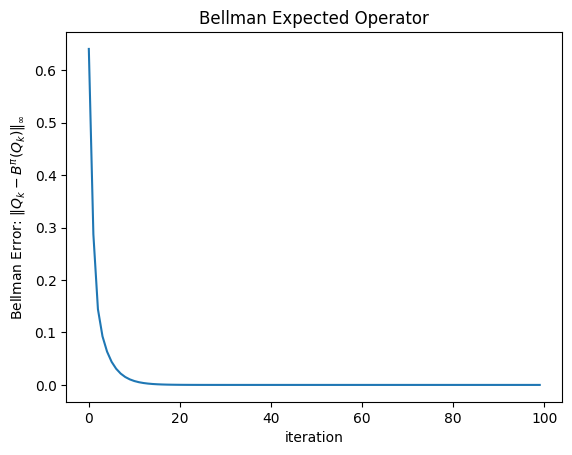

In [ ]:
import matplotlib.pyplot as plt

# 適当な方策を作ります
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / np.sum(policy, axis=1, keepdims=True)

Q = np.random.rand(mdp.S, mdp.A)  # Q関数の初期値です
errors = []
# ベルマン期待作用素を繰り返し適用して、収束するか確認してみます
for i in range(100):
    BQ = Bellman_expected_operator(mdp, gamma, Q, policy)
    errors.append(np.abs(Q - BQ).max())
    Q = BQ

print("最初の誤差:", errors[0])
print("最終的な誤差：", errors[-1])
plt.plot(errors)
plt.title("Bellman Expected Operator")
plt.ylabel("Bellman Error: " + r"$\|Q_k - B^\pi(Q_{k})\|_\infty$")
plt.xlabel("iteration")

最初の誤差: 1.3227388937656097
最終的な誤差： 4.440892098500626e-16


Text(0.5, 0, 'iteration')

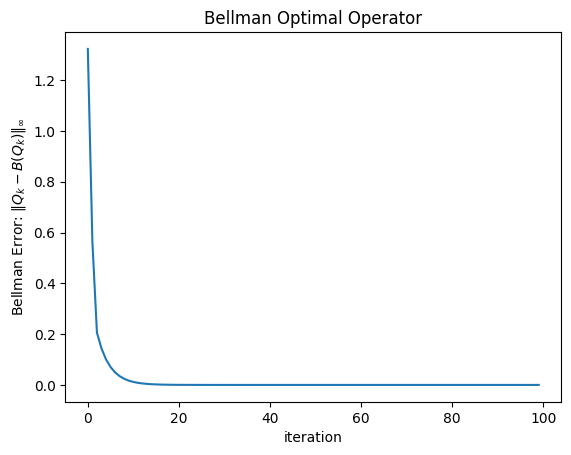

In [ ]:
import matplotlib.pyplot as plt

Q = np.random.rand(mdp.S, mdp.A)  # Q関数の初期値です
errors = []
# ベルマン最適作用素を繰り返し適用して、収束するか確認してみます
for i in range(100):
    BQ = Bellman_optimal_operator(mdp, gamma, Q)
    errors.append(np.abs(Q - BQ).max())
    Q = BQ

print("最初の誤差:", errors[0])
print("最終的な誤差：", errors[-1])
plt.plot(errors)
plt.title("Bellman Optimal Operator")
plt.ylabel("Bellman Error: " + r"$\|Q_k - B(Q_{k})\|_\infty$")
plt.xlabel("iteration")

最後に，後で便利なので，ベルマン期待作用素を使って方策の期待収益を計算する関数を作ります．これはモンテカルロ近似よりも精度が良いです．

授業の内容を思い出すと，期待収益とQ値には次の関係が成立します：

$$
\mathbb{E}^\pi[R] = \sum_{a\in A}\pi(a \mid s_0) Q^\pi(s_0, a)
$$

In [ ]:
def ExpectedReturnBellman(mdp: MDP, gamma: float, policy: np.ndarray):
  """期待収益をベルマン期待作用素で近似します．
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    policy (np.ndarray): 期待収益を近似したい方策です
  """
  Q = np.random.rand(mdp.S, mdp.A)  # Q関数の初期値です
  # 収束するまでベルマン期待作用素を繰り返し適用します
  while True:
      BQ = Bellman_expected_operator(mdp, gamma, Q, policy)
      if np.abs(Q - BQ).max() <= 1e-4:
        break  #  収束したら抜けます
      Q = BQ
  expected_return = (policy * Q).sum(axis=-1)[mdp.s0]  # Q値から収益に直します
  return expected_return


# テストです
policy = np.random.rand(mdp.S, mdp.A)
policy = policy / policy.sum(axis=-1, keepdims=True)
print("適当な方策の期待収益：", ExpectedReturnBellman(mdp, gamma, policy))

適当な方策の期待収益： 1.493573421326876


## 価値反復法と方策反復法

ベルマン期待作用素もベルマン最適作用素も，ベルマン誤差が収束していく様子が確認できました．これを利用するのが**価値反復法**と**方策反復法**です．実装してみましょう．
価値反復法は次を繰り返します．（ここで$\operatorname{Gr}(Q)$は$Q\in \mathbb{R}^{S\times A}$ に対する貪欲方策です）

* 方策更新：$\pi_{k+1} = \operatorname{Gr}(Q_k)$
* 方策評価：$Q_{k+1} = B^{\pi_{k+1}}(Q_k)$

授業でやったように，これはベルマン最適作用素$Q_{k+1} = B(Q_k)$による更新と等価です．

せっかくなので，ちょっと難しめのマルコフ決定過程を作ってみます（遷移と報酬がスパースです．実装をみて考えてみましょう．）

In [ ]:
import numpy as np
from dataclasses import dataclass

# 大きめのマルコフ決定過程で実験してみます．サイズを変えて遊んでみてください．
_S = 40  # 状態集合のサイズ
_A = 10   # 行動集合のサイズ
_S_set = np.arange(_S)  # 状態集合．初期状態は_S_set[0]とします．
_A_set = np.arange(_A)  # 行動集合

# 報酬行列を適当に作ります．どこか一つの状態行動だけが正解な，スパースな報酬を作ります．
_rew = np.zeros((_S * _A))
_rew[np.random.choice(_S*_A)] = 1.0
_rew = _rew.reshape(_S, _A)
assert _rew.shape == (_S, _A)

# 遷移確率行列を適当に作ります．遷移先がスパースになるように作ります．
_P = np.random.dirichlet(alpha=[0.01] * _S, size=(_S*_A))
_P = _P.reshape(_S, _A, _S)
np.testing.assert_almost_equal(_P.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します


mdp = MDP(_S_set, _A_set, _rew, _P)
print("報酬関数のshape", mdp.rew.shape)
print("遷移確率行列のshape",mdp.P.shape)
print("初期状態", mdp.s0)

報酬関数のshape (40, 10)
遷移確率行列のshape (40, 10, 40)
初期状態 0


In [ ]:
def compute_greedy_policy(Q: np.ndarray):
  """与えられたQ関数に対して貪欲方策を計算します
  Args:
    Q (np.ndarray): SxAの行列
  """
  S, A = Q.shape
  policy = np.zeros((S, A))
  policy[np.arange(S), Q.argmax(axis=1)] = 1.0 # 貪欲方策を計算します
  return policy


def ValueIteration(mdp: MDP, gamma: float, iteration: int):
  """価値反復法アルゴリズムです．
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    iteration (int): イテレーションの回数です
  """
  Q = np.zeros((mdp.S, mdp.A)) # 適当なQの初期値を生成します
  for _ in range(iteration): # ベルマン最適作用素を繰り返し適用します
    Q = Bellman_optimal_operator(mdp, gamma, Q)
  return compute_greedy_policy(Q)

価値反復法が実装できました！
価値反復法のイテレーションに応じて，得られる収益がどれくらいになるか見てみましょう．

最初の収益: 0.009928302593112382
収束後の収益： 22.24752259408514


Text(0.5, 0, 'iteration')

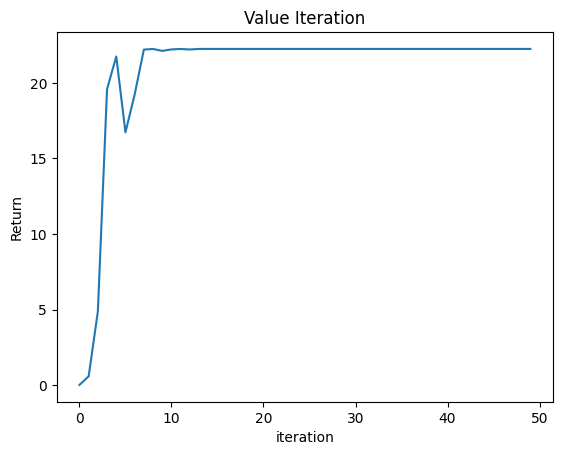

In [ ]:
gamma = 0.99
returns = []
for iteration in range(50):
  policy_VI = ValueIteration(mdp, gamma, iteration)
  return_VI = ExpectedReturnBellman(mdp, gamma, policy_VI)
  returns.append(return_VI)


print("最初の収益:", returns[0])
print("収束後の収益：", returns[-1])
plt.plot(returns)
plt.title("Value Iteration")
plt.ylabel("Return")
plt.xlabel("iteration")

続いて，方策反復法を実装します．方策反復法はベルマン期待作用素を十分な回数実行し，$Q^\pi$を計算します．

* 方策更新：$\pi_{k+1} = \operatorname{Gr}(Q_k)$
* 方策評価：$Q_{k+1} = Q^{\pi_{k+1}}$

In [ ]:
def PolicyIteration(mdp: MDP, gamma: float, iteration: int):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    iteration (int): 方策更新の回数です
  """
  Q = np.zeros((mdp.S, mdp.A)) # 適当なQの初期値を生成します
  policy = np.ones((mdp.S, mdp.A)) / mdp.A  # 適当な方策の初期値を生成します
  for _ in range(iteration): # 方策更新を繰り返します

    # 十分な回数ベルマン期待作用素を繰り返してQpiを計算します
    for _ in range(100):
      Q = Bellman_expected_operator(mdp, gamma, Q, policy)

    # 方策更新をします
    policy = compute_greedy_policy(Q)
  return policy

方策反復法が実装できました！
方策反復法のイテレーションに応じて，得られる収益がどれくらいになるか見てみましょう．

最初の収益: 0.15565560410758736
収束後の収益： 22.247476468494074


Text(0.5, 0, 'iteration')

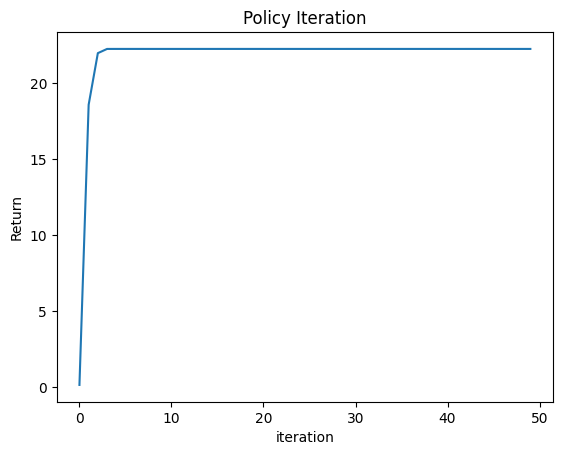

In [ ]:
gamma = 0.99
returns = []
for iteration in range(50):
  policy_PI = PolicyIteration(mdp, gamma, iteration)
  return_PI = ExpectedReturnBellman(mdp, gamma, policy_PI)
  returns.append(return_PI)


print("最初の収益:", returns[0])
print("収束後の収益：", returns[-1])
plt.plot(returns)
plt.title("Policy Iteration")
plt.ylabel("Return")
plt.xlabel("iteration")

**補足**
実は方策反復法の方が価値反復法よりも（イテレーションの意味で）素早く収束することが知られています．実験の結果もそうなっていますか？

参考：https://rltheory.github.io/lecture-notes/planning-in-mdps/lec4/

## マルチステップ方策評価・方策更新を実装しよう

授業でやったマルチステップ期待ベルマン作用素とマルチステップ最適ベルマン作用素を実装しましょう．

* マルチステップ期待ベルマン作用素 $B^\pi_m: \mathbb{R}^{S\times A}\to \mathbb{R}^{S\times A}$：$B^\pi_m(Q) = B^\pi(B^\pi(B^\pi(\cdots (Q))))$
* マルチステップ最適ベルマン作用素 $B_n: \mathbb{R}^{S\times A}\to \mathbb{R}^{S\times A}$：$B_n(Q) = B(B(B(\cdots(Q))))$


また，マルチステップ貪欲方策も実装します．
* マルチステップ貪欲方策：$\operatorname{Gr}(B_n(Q))$

In [ ]:
def MultiStep_Bellman_expected_operator(mdp: MDP, gamma: float, Q: np.ndarray, policy: np.ndarray, m: int):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    Q (np.ndarray): ベルマン期待作用素に入力するQ関数です
    policy (np.ndarray): ベルマン期待作用素で使う方策です
    m (int): マルチステップ数
  """
  assert m >= 0
  S, A = mdp.S, mdp.A
  # 方策とQ関数はSxAの行列です
  assert Q.shape == (S, A)
  assert policy.shape == (S, A)

  for _ in range(m):
    policy_Q = (policy * Q).sum(axis=1) # πQです
    P_policy_Q = mdp.P @ policy_Q  # P(πQ)です
    Q = mdp.rew + gamma * P_policy_Q # ベルマン期待作用素の結果です
  return Q


def MultiStep_Bellman_optimal_operator(mdp: MDP, gamma: float, Q: np.ndarray, n: int):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    Q (np.ndarray): ベルマン期待作用素に入力するQ関数です
    n (int): マルチステップ数
  """
  assert n >= 0
  # Q関数はSxAの行列です
  assert Q.shape == (mdp.S, mdp.A)

  for _ in range(n):
    max_Q = Q.max(axis=1) # maxQです
    P_max_Q = mdp.P @ max_Q # P(maxQ)です
    Q = mdp.rew + gamma * P_max_Q # ベルマン最適作用素の結果です
  return Q


def MultiStep_greedy_policy(mdp: MDP, gamma: float, Q: np.ndarray, n: int):
  """与えられたQ関数とmdpに対して，nステップ先読みした貪欲方策を計算します．
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    Q (np.ndarray): SxAの行列
  """
  BQ = MultiStep_Bellman_optimal_operator(mdp, gamma, Q, n)
  policy = compute_greedy_policy(BQ)
  return policy

最後にマルチステップ方策評価＆更新を実装しましょう．

* マルチステップ方策更新：$\pi_{k+1} = \operatorname{Gr}(B_n(Q_k))$
* マルチステップ方策評価：$Q_{k+1} = B_m^{\pi_{k+1}}(Q_k)$


In [ ]:
def MultiStepPolicyIteration(mdp: MDP, gamma: float, update_step: int, eval_step: int, iteration: int):
  """
  Args:
    mdp (MDP): マルコフ決定過程です.（S, A, P, r)を持っています．
    gamma (float): 割引率(0 <= gamma <= 1)です
    update_step (int): 方策更新のステップ数
    eval_step (int): 方策評価のステップ数
    iteration (int): 方策更新の回数です
  """
  Q = np.zeros((mdp.S, mdp.A)) # 適当なQの初期値を生成します
  policy = np.ones((mdp.S, mdp.A)) / mdp.A  # 適当な方策の初期値を生成します
  for _ in range(iteration): # 方策更新を繰り返します
    Q = MultiStep_Bellman_expected_operator(mdp, gamma, Q, policy, eval_step)
    policy = MultiStep_greedy_policy(mdp, gamma, Q, update_step)
  return policy

マルチステップ方策評価＆更新の挙動を確認してみましょう．
授業でやったように，$(m, n)=(1, 0)$なら価値反復法，$(m, n)=(\infty, 0)$なら方策反復法です．
$m, n$を変えたらどうなるか見てみましょう．

100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


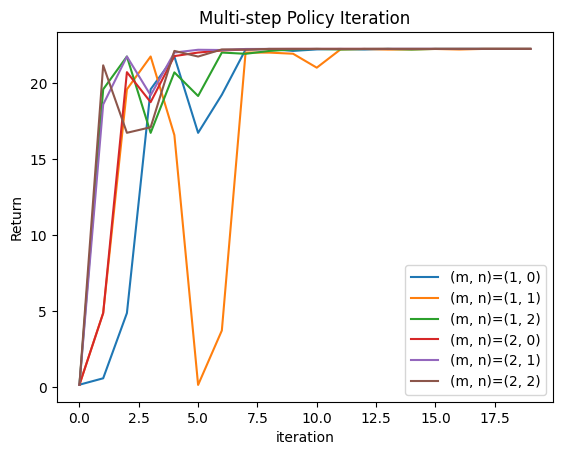

In [ ]:
from tqdm import tqdm

gamma = 0.99

for m in tqdm(range(1, 3)):
  for n in range(0, 3):
    returns = []
    for iteration in range(20):
      policy_multi = MultiStepPolicyIteration(mdp, gamma,n, m, iteration)
      return_multi = ExpectedReturnBellman(mdp, gamma, policy_multi)
      returns.append(return_multi)
    plt.plot(returns, label=f"(m, n)=({m}, {n})")
plt.title("Multi-step Policy Iteration")
plt.ylabel("Return")
plt.xlabel("iteration")

plt.legend()

ステップ数が変わると何が起きるか？については，こちらの論文を参照してください．

* https://arxiv.org/abs/2103.00107
* https://arxiv.org/abs/1805.07956
* https://arxiv.org/abs/1802.03654

# もっと発展的な動的計画法

今回は行列形式で動的計画法の実装を確認しました。練習として、自分の力で次の論文たちを実装してみてください。

* [Leverage the Average: an Analysis of KL Regularization in RL](https://arxiv.org/abs/2003.14089)
* [Theoretical Analysis of Efficiency and Robustness of Softmax and Gap-Increasing Operators in Reinforcement Learning](https://proceedings.mlr.press/v89/kozuno19a.html)

Pがわからない場合は今回の行列形式はどうなるでしょうか?以下が参考になります：

* [Generalized Markov Decision Processes: Dynamic-programming and Reinforcement-learning Algorithms](https://sites.ualberta.ca/~szepesva/papers/gmdp.ps.pdf)
